# Spherepop Playground Notebook

This notebook is a minimal executable toy model of **Spherepop**.

Core ideas demonstrated:
- Spheres are delayed irreversible events.
- `pop()` evaluates exactly once and records history.
- Identity is defined by event history, not by value.
- Nested scopes compose into larger structures.
- Event histories form a geometry that can be visualized.

In [1]:
import uuid
from dataclasses import dataclass, field
from typing import Callable, Any, List, Tuple, Dict
import matplotlib.pyplot as plt
import math
import random


## Minimal Event History Example

We construct a small irreversible computation to generate a non-trivial
event history suitable for visualization.

In [2]:
@dataclass
class Event:
    eid: str
    label: str
    value: Any
    parents: Tuple[str, ...]

@dataclass
class History:
    events: Dict[str, Event] = field(default_factory=dict)

    def add(self, event: Event):
        self.events[event.eid] = event

    def lineage(self, eid: str) -> List[str]:
        seen = set()
        order = []
        def dfs(x):
            if x in seen:
                return
            seen.add(x)
            for p in self.events[x].parents:
                dfs(p)
            order.append(x)
        dfs(eid)
        return order

@dataclass
class Sphere:
    label: str
    thunk: Callable[['History'], Any]
    _eid: str = None

    def pop(self, history: History):
        if self._eid is not None:
            return history.events[self._eid].value, self._eid
        value, parents = self.thunk(history)
        eid = str(uuid.uuid4())
        history.add(Event(eid, self.label, value, parents))
        self._eid = eid
        return value, eid

def const(label, x):
    return Sphere(label, lambda h: (x, ()))

def add(label, a, b):
    def thunk(h):
        va, ea = a.pop(h)
        vb, eb = b.pop(h)
        return va + vb, (ea, eb)
    return Sphere(label, thunk)

def mul(label, a, b):
    def thunk(h):
        va, ea = a.pop(h)
        vb, eb = b.pop(h)
        return va * vb, (ea, eb)
    return Sphere(label, thunk)

H = History()
expr = mul('mul', add('add', const('one',1), const('two',2)), const('three',3))
value, root = expr.pop(H)
value


9

## Radial Causal Visualization

Events are embedded radially by causal depth. Angular position separates
branches, yielding a geometric representation of the event partial order.

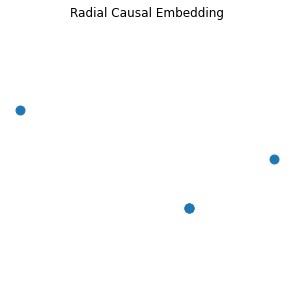

In [3]:
def depth(h, eid):
    e = h.events[eid]
    if not e.parents:
        return 0
    return 1 + max(depth(h, p) for p in e.parents)

roots = [eid for eid,e in H.events.items() if not e.parents]
angles = {}

def assign_angles(eid, theta):
    angles[eid] = theta
    children = [e.eid for e in H.events.values() if eid in e.parents]
    if not children:
        return
    spread = math.pi / max(1, len(children))
    for i,c in enumerate(children):
        assign_angles(c, theta + (i - len(children)/2)*spread)

for i,r in enumerate(roots):
    assign_angles(r, 2*math.pi*i/max(1,len(roots)))

xs, ys = [], []
for eid in H.events:
    r = depth(H, eid)
    theta = angles.get(eid, random.uniform(-math.pi, math.pi))
    xs.append(r*math.cos(theta))
    ys.append(r*math.sin(theta))

plt.figure(figsize=(5,5))
plt.scatter(xs, ys, s=80)
plt.axis('equal')
plt.axis('off')
plt.title('Radial Causal Embedding')
plt.show()


## Lineage Heatmap

A smooth scalar field is constructed by superposing radial basis functions
along event lineages, producing a continuous visualization of causal density.

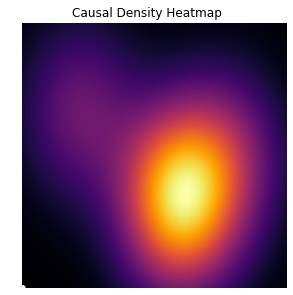

In [4]:
import numpy as np

points = np.array(list(zip(xs, ys)))
res = 300
x = np.linspace(points[:,0].min()-1, points[:,0].max()+1, res)
y = np.linspace(points[:,1].min()-1, points[:,1].max()+1, res)
xx, yy = np.meshgrid(x, y)

field = np.zeros_like(xx)
for (px,py) in points:
    field += np.exp(-((xx-px)**2 + (yy-py)**2))

plt.figure(figsize=(5,5))
plt.imshow(field, origin='lower', cmap='inferno')
plt.scatter(points[:,0], points[:,1], c='white', s=10)
plt.axis('off')
plt.title('Causal Density Heatmap')
plt.show()
